# Step 2: Add SageMaker AI processing and training jobs

<div class="alert alert-warning"> This notebook has been last tested on a SageMaker Studio JupyterLab instance using the <code>SageMaker Distribution Image 3.0.1</code> and with the SageMaker Python SDK version <code>2.245.0</code></div>

In this step you move data processing and model training into [SageMaker Docker containers](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html) and use [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/index.html) to interact with SageMaker.

||||
|---|---|---|
|1. |Experiment in a notebook ||
|2. |Scale with SageMaker AI processing jobs and SageMaker SDK |**<<<< YOU ARE HERE**|
|3. |Operationalize with ML pipeline, model registry, and feature store ||
|4. |Add a model building CI/CD pipeline ||
|5. |Add a model deployment pipeline ||
|6. |Add model and data monitoring ||

SageMaker makes use of Docker containers to enable developers to process data, train and deploy models. Containers allow developers and data scientists to package software into standardized units that run consistently on any platform that supports Docker. Containers ensure that code, runtime, system tools, system libraries, and settings are all in the same place, isolating them from the execution environment. It guarantees a consistent runtime experience regardless of where a container is being run.

SageMaker also provides pre-build containers with popular data processing frameworks and ML algorithms. All SageMaker built-in algorithms are delivered as Docker containers.

<div class="alert alert-info"> Make sure you using <code>Python 3</code> kernel in JupyterLab for this notebook.</div>

In [1]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

Stored variables and their in-db values:
baseline_s3_url                         -> 's3://sagemaker-us-east-1-906545278380/from-idea-t
bucket_name                             -> 'sagemaker-us-east-1-906545278380'
bucket_prefix                           -> 'from-idea-to-prod/xgboost'
dataset_feature_group_name              -> 'from-idea-to-prod-20-12-09-53'
dataset_file_local_path                 -> 'data/bank-additional/bank-additional-full.csv'
domain_id                               -> 'd-igloxuzrs3z2'
evaluation_s3_url                       -> 's3://sagemaker-us-east-1-906545278380/from-idea-t
experiment_name                         -> 'from-idea-to-prod-experiment-19-17-15-04'
feature_store_bucket_prefix             -> 'from-idea-to-prod/feature-store'
initialized                             -> True
input_s3_url                            -> 's3://sagemaker-us-east-1-906545278380/from-idea-t
mlflow_arn                              -> 'arn:aws:sagemaker:us-east-1:906545278380:mlflow

In [2]:
import time
import boto3
import botocore
import numpy as np  
import pandas as pd  
import sagemaker
import os
import mlflow
from time import gmtime, strftime, sleep
from sagemaker.processing import FrameworkProcessor, ProcessingInput, ProcessingOutput
from sagemaker.sklearn.estimator import SKLearn
from sklearn.metrics import roc_auc_score
from mlflow import MlflowClient
from IPython.display import Javascript
from importlib.metadata import version, PackageNotFoundError
from IPython.display import HTML

sagemaker.__version__

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Fetched defaults config from location: /home/sagemaker-user/.config/sagemaker/config.yaml


'2.228.0'

In [74]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
session = sagemaker.Session()
sm = session.sagemaker_client
training_job_name = None

## Prepare an MLflow experiment
Re-use the existing experiment we created in the previous notebook. You're going to track new runs in the same experiment.
You can also create a new experiment to track runs in this notebook – in this case just uncomment the following code cell.

In [4]:
experiment_suffix = strftime('%d-%H-%M-%S', gmtime())
registered_model_name = f"from-idea-to-prod-job-model-{experiment_suffix}"

In [6]:
# Uncomment code block (Cmd + /) if you would like to create a new experiment

# experiment_name = f"from-idea-to-prod-experiment-{experiment_suffix}"

In [9]:
print(f'Using MLflow server: {mlflow_arn}')
mlflow.set_tracking_uri(mlflow_arn)
experiment = mlflow.set_experiment(experiment_name=experiment_name)

Using MLflow server: arn:aws:sagemaker:us-east-1:906545278380:mlflow-tracking-server/test-mlflow


## Process data with SageMaker processing jobs
Use [SageMaker Processing](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) by simply providing a Python script and choosing a [SageMaker SDK processor](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html) class.

You must upload the input data to S3 and specify an S3 location for output data. SageMaker Processing automatically loads the input data from S3 and uploads transformed data back to S3 when the job is complete. The processing container image can either be an Amazon SageMaker built-in image or a custom image that you provide. The underlying infrastructure for a processing job is fully managed by Amazon SageMaker. Cluster resources are provisioned for the duration of your job, and cleaned up when a job completes.

![](img/sagemaker-processing.png)

This section demonstrates different options to execute data processing scripts using SageMaker infrastructure:
1. Run processing in a built-in SageMaker container in local and remote modes
2. Run processing code as a remote function locally and remotely using SageMaker Distribution Image container

Your input data must be stored in an Amazon S3 bucket. Alternatively, you can use [Amazon Athena](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.dataset_definition.inputs.AthenaDatasetDefinition) or [Amazon Redshift](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.dataset_definition.inputs.AthenaDatasetDefinition) as input sources.

Upload the input dataset to an Amazon S3 bucket:

In [10]:
input_s3_url = session.upload_data(
    path="data/bank-additional/bank-additional-full.csv",
    bucket=bucket_name,
    key_prefix=f"{bucket_prefix}/input"
)

%store input_s3_url

Stored 'input_s3_url' (str)


In [11]:
# !aws s3 ls {bucket_name}/{bucket_prefix} --recursive

### Run processing script in a SageMaker Framework container
You start with running your data processing script in a SageMaker built-in managed container in local mode. [Local mode](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-updated-local.html) allows to run SageMaker jobs on the local development environment or on a SageMaker Space instance. This feature is useful for testing and debugging scripts without creating remote compute instances before running them as SageMaker remote jobs or pipelines.

Note that while you can use local mode for your scripts running in a SageMaker built-in container or in your own container (BYOC), some SageMaker built-in algorithm containers like XGBoost don't support local mode. 

<div class="alert alert-info">Make sure you installed Docker in the notebook 00. You can also skip the local training and go direct to the <b>Step 2</b>.</div>

Since you're using MLflow in the processing script, you need to provide a `requirements.txt` so that the container installs mlflow and MLflow SageMaker plugin before running the processing script.

In [12]:
dependencies_dir="./processing/requirements/"
%mkdir -p processing
%mkdir -p {dependencies_dir}

In [13]:
# replicate the current package versions in the script container environment
packages = ['mlflow', 'sagemaker-mlflow']
requirements = [f'{p}=={version(p)}' for p in packages]

if requirements:
    with open(f'{dependencies_dir}/requirements.txt', 'w') as f:
        f.write('\n'.join(requirements))
    print("\nNew requirements.txt file created with the following content:")
    print('\n'.join(requirements))
else:
    print("\nNo requirements.txt file created as no packages were found")


New requirements.txt file created with the following content:
sagemaker==2.228.0
mlflow==2.20.0
sagemaker-mlflow==0.1.0


Create a Python script by moving the data processing code from the step 1 notebook to a .py file and adding experiment tracking with MLflow:

In [14]:
%%writefile processing/preprocessing.py

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pandas as pd
import numpy as np
import argparse
import os

from time import gmtime, strftime, sleep
import traceback

import mlflow

user_profile_name = os.getenv('USER')

def _parse_args():
    
    parser = argparse.ArgumentParser()
    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='bank-additional-full.csv')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')
    
    return parser.parse_known_args()

def process_data(df_data):
    # Indicator variable to capture when pdays takes a value of 999
    df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

    # Indicator for individuals not actively employed
    df_data["not_working"] = np.where(
        np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
    )

    # remove unnecessary data
    df_model_data = df_data.drop(
        ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
        axis=1,
    )

    bins = [18, 30, 40, 50, 60, 70, 90]
    labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']

    df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
    df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
    df_model_data.drop('age', axis=1, inplace=True)
    df_model_data.drop('age_range', axis=1, inplace=True)

    scaled_features = ['pdays', 'previous', 'campaign']
    df_model_data[scaled_features] = MinMaxScaler().fit_transform(df_model_data[scaled_features])

    df_model_data = pd.get_dummies(df_model_data, dtype=int)  # Convert categorical variables to sets of indicators

    # Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
    df_model_data = pd.concat(
        [
            df_model_data["y_yes"].rename(target_col),
            df_model_data.drop(["y_no", "y_yes"], axis=1),
        ],
        axis=1,
    )
    
    return df_model_data

if __name__=="__main__":
    # Process arguments
    args, _ = _parse_args()
    
    target_col = "y"

    # Set the Tracking Server URI using the ARN of the Tracking Server you created
    mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_ARN'])
    
    # Enable autologging in MLflow
    mlflow.autolog()

    # Use the active run_id to log 
    with mlflow.start_run(run_id=os.environ['MLFLOW_RUN_ID']) as run:
        # process data
        df_model_data = process_data(pd.read_csv(os.path.join(args.filepath, args.filename), sep=";"))
    
        # Shuffle and splitting dataset
        train_data, validation_data, test_data = np.split(
            df_model_data.sample(frac=1, random_state=1729),
            [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
        )
    
        print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")
        mlflow.log_params(
            {
                "train": train_data.shape,
                "validate": validation_data.shape,
                "test": test_data.shape
            }
        )

        mlflow.set_tags(
            {
                'mlflow.user':user_profile_name,
                'mlflow.source.type':'JOB'
            }
        )
        
        # Save datasets locally
        train_data.to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
        validation_data.to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
        test_data[target_col].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
        test_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)
        
        # Save the baseline dataset for model monitoring
        df_model_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'baseline/baseline.csv'), index=False, header=False)

        mlflow.log_artifact(local_path=os.path.join(args.outputpath, 'baseline/baseline.csv'))
    
    print("## Processing complete. Exiting.")

Overwriting processing/preprocessing.py


The processing script contains a statement to save the whole dataset without the header and the label column as a baseline dataset. You need the data baseline later on in the model monitoring notebook.

Set the Amazon S3 paths:

In [15]:
train_s3_url = f"s3://{bucket_name}/{bucket_prefix}/train"
validation_s3_url = f"s3://{bucket_name}/{bucket_prefix}/validation"
test_s3_url = f"s3://{bucket_name}/{bucket_prefix}/test"
baseline_s3_url = f"s3://{bucket_name}/{bucket_prefix}/baseline"

In [16]:
%store train_s3_url
%store validation_s3_url
%store test_s3_url
%store baseline_s3_url

Stored 'train_s3_url' (str)
Stored 'validation_s3_url' (str)
Stored 'test_s3_url' (str)
Stored 'baseline_s3_url' (str)


Set the framework version:

In [17]:
skprocessor_framework_version = '1.2-1'

#### Create a experiment run
Create a new run in your experiment to track parameters, configuration, inputs, and outputs of the processing job.

In [18]:
run_suffix = strftime('%d-%H-%M-%S', gmtime())
run_name = f"container-processing-{run_suffix}"

run_id = mlflow.start_run(
    run_name=run_name,
    description="feature-engineering in the notebook 02 with a processing job").info.run_id

#### Create a processor and set inputs and outputs
Instantiate a [`FrameworkProcessor`](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html) object before starting the SageMaker processing job. You set the instance type to `local` to activate the local mode and provide `sagemaker.LocalSession()` object as `sagemaker_session` parameter.

Note how SageMaker maps your data to the local paths on the processing container's EBS volume:

![](img/data-processing.png)

In [20]:
sklearn_processor = FrameworkProcessor(
    estimator_cls=SKLearn,
    framework_version=skprocessor_framework_version,
    role=sm_role,
    instance_type='local',
    instance_count=1,
    base_job_name='from-idea-to-prod-processing',
    sagemaker_session=sagemaker.LocalSession(), 
    env={
        'MLFLOW_TRACKING_ARN': mlflow_arn,
        'MLFLOW_RUN_ID': run_id,
        'USER': user_profile_name
    }
)

processing_inputs = [
        ProcessingInput(
            source=input_s3_url, 
            destination="/opt/ml/processing/input",
            # s3_input_mode="File",
            # s3_data_distribution_type="ShardedByS3Key"
        ),
        ProcessingInput(
            input_name="processor",
            source=dependencies_dir,
            destination="/opt/ml/processing/input/code/requirements/",
        ),
    ]

processing_outputs = [
        ProcessingOutput(
            output_name="train_data", 
            source="/opt/ml/processing/output/train",
            destination=train_s3_url,
        ),
        ProcessingOutput(
            output_name="validation_data", 
            source="/opt/ml/processing/output/validation", 
            destination=validation_s3_url
        ),
        ProcessingOutput(
            output_name="test_data", 
            source="/opt/ml/processing/output/test", 
            destination=test_s3_url
        ),
        ProcessingOutput(
            output_name="baseline_data", 
            source="/opt/ml/processing/output/baseline", 
            destination=baseline_s3_url
        ),
    ]

<div class="alert alert-info">If you get an error <code>No such file or directory: 'docker'</code> in the code below, you need to run the section <b>Install Docker to enable Studio local mode</b> from the notebook 00.</div>

#### Start the SageMaker processing job



The first time the processor runs, it authenticates docker to ECR and pulls the base SageMaker sklearn image. Subsequent processor runs are faster.

In [ ]:
sklearn_processor.run(
    inputs=processing_inputs,
    outputs=processing_outputs,
    code='processing/preprocessing.py',
    dependencies=[f'{dependencies_dir}requirements.txt'],
    # arguments = ['arg1', 'arg2'],
)

mlflow.set_tags(
    {
        'mlflow.source.name':f'https://{region}.console.aws.amazon.com/sagemaker/home?region={region}#/processing-jobs/{sklearn_processor.latest_job.name}',
    }
)

mlflow.end_run()

In [23]:
# check that the processing script uploaded the dataset to the S3 prefix
!aws s3 ls {train_s3_url}/

2025-02-11 11:30:19    4265155 train.csv


### Run processing script locally and remotely as a SageMaker job
Now you use [SageMaker Python SDK decorator `@remote`](https://sagemaker.readthedocs.io/en/stable/remote_function/sagemaker.remote_function.html) to run you local code in the notebook as a SageMaker processing job – called the "Remote Function". This is an even easier way to run your Python code at scale using SageMaker distributed processing and training. Refer to the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/train-remote-decorator.html) in the Amazon SageMaker developer guide.

Another option to run processing jobs is using the [`RemoteExecutor`](https://sagemaker.readthedocs.io/en/stable/remote_function/sagemaker.remote_function.html#remoteexecutor) a SageMaker Python SDK class that allows you to run a local function remotely as a SageMaker job. You can run multiple jobs in paralle using `max_parallel_jobs` parameter to control the max number of parallel jobs


In the following section you run the data processing code as a SageMaker job using both the `@remote` decorator and the RemoteExecutor API.



#### Step 1: Develop and test you code locally
First, you implement and test your code locally in the notebook to verify the correctness of code and environment.

In [24]:
# Load the dataset in to DataFrame
file_name = "bank-additional-full.csv"
input_path = "./data/bank-additional" 
df_data = pd.read_csv(os.path.join(input_path, file_name), sep=";")

In [25]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# define a local function
def preprocess(
    df_data,
    tracking_server_arn=mlflow_arn,
    experiment_name=None,
    run_id=None,
):
    import mlflow
    from time import gmtime, strftime

    try:
        # Set the Tracking Server URI using the ARN of the Tracking Server you created
        mlflow.set_tracking_uri(tracking_server_arn)
        
        # Enable autologging in MLflow
        mlflow.autolog()
    
        suffix = strftime('%d-%H-%M-%S', gmtime())
        mlflow.set_experiment(experiment_name=experiment_name if experiment_name else f"preprocess-{suffix}")
        run = mlflow.start_run(run_id=run_id) if run_id else mlflow.start_run(run_name=f"local-processing-{suffix}", nested=True)
    
        target_col = "y"
        
        # Indicator variable to capture when pdays takes a value of 999
        df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)
    
        # Indicator for individuals not actively employed
        df_data["not_working"] = np.where(
            np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
        )
    
        # remove unnecessary data
        df_model_data = df_data.drop(
            ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
            axis=1,
        )
    
        bins = [18, 30, 40, 50, 60, 70, 90]
        labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']
    
        df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
        df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
        df_model_data.drop('age', axis=1, inplace=True)
        df_model_data.drop('age_range', axis=1, inplace=True)
    
        scaled_features = ['pdays', 'previous', 'campaign']
        df_model_data[scaled_features] = MinMaxScaler().fit_transform(df_model_data[scaled_features])
    
        df_model_data = pd.get_dummies(df_model_data, dtype=int)  # Convert categorical variables to sets of indicators
    
        # Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
        df_model_data = pd.concat(
            [
                df_model_data["y_yes"].rename(target_col),
                df_model_data.drop(["y_no", "y_yes"], axis=1),
            ],
            axis=1,
        )
    
        # Shuffle and splitting dataset
        train_data, validation_data, test_data = np.split(
            df_model_data.sample(frac=1, random_state=1729),
            [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
        )
    
        print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")

        mlflow.log_params(
            {
                "train": train_data.shape,
                "validate": validation_data.shape,
                "test": test_data.shape
            }
        )
        
        baseline_data = df_model_data.drop([target_col], axis=1)
        
        print("## Processing complete. Exiting.")
        
        return train_data, validation_data, test_data, baseline_data

    except Exception as e:
        print(f"Exception in processing script: {e}")
        raise e
    finally:
        mlflow.end_run()

In [26]:
# Call the function locally
train_data, validation_data, test_data, baseline_data = preprocess(df_data, experiment_name=experiment_name)

2025/02/11 11:51:53 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/02/11 11:51:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/02/11 11:51:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Data split > train:(28831, 65) | validation:(8238, 65) | test:(4119, 65)
## Processing complete. Exiting.
🏃 View run local-processing-11-11-51-53 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/34/runs/0934f4e924b44720805a2ecf7fe0d43d
🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/34


In [27]:
# see the processed data
train_data.head()

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18-29,age_30-39,age_40-49,age_50-59,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
40949,0,0.036364,1.0,0.0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0
9332,0,0.018182,1.0,0.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
32286,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3925,0,0.036364,1.0,0.0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
9406,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


#### Step 2: Execute the function remotely using RemoteExecutor


In [28]:
from sagemaker.remote_function import remote, RemoteExecutor

In [29]:
s3_root_uri = f"s3://{bucket_name}/{bucket_prefix}"

In [30]:
# this code will start a SageMaker job to execute prerpocess script
with RemoteExecutor(dependencies=f"{dependencies_dir}requirements.txt",
                    s3_root_uri=s3_root_uri, instance_type='ml.m5.xlarge') as e:
    future = e.submit(preprocess, df_data)                 

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2025-02-11 11:52:23,880 sagemaker.remote_function INFO     Serializing function code to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/preprocess-2025-02-11-11-52-23-880/function
2025-02-11 11:52:24,053 sagemaker.remote_function INFO     Serializing function arguments to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/preprocess-2025-02-11-11-52-23-880/arguments
2025-02-11 11:52:24,837 sagemaker.remote_function INFO     Copied user workspace to '/tmp/tmpsnfzzh8h/temp_workspace/sagemaker_remote_function_workspace'
2025-02-11 11:52:24,839 sagemaker.remote_function INFO     Copied dependencies file at './processing/requirements/requirements.txt' to '/tmp/tmpsnfzzh8h/temp_workspace/sagemaker_remote_function_workspace/requirements.txt'
2025-02-11 11:52:27,173 sagemaker.remote_function INFO     Successfully created workdir archive at '/tmp/tmpsnfzzh8h/workspace.zip'
2025-02-11 11:52:27,701 sagemaker.remote_function INFO     Successfully uploaded workdir to 's

In [ ]:
# the call future.results() fetches the job execution logs and deserializes the script output back to the objects
train_data, validation_data, test_data, baseline_data = future.result()

In [32]:
# see the processed data
train_data.head()

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18-29,age_30-39,age_40-49,age_50-59,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
40949,0,0.036364,1.0,0.0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0
9332,0,0.018182,1.0,0.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
32286,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3925,0,0.036364,1.0,0.0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
9406,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


#### Step 3: Run code with @remote decorator
You can also set default settings for remote functions via a [configuration file](https://docs.aws.amazon.com/sagemaker/latest/dg/train-remote-decorator-config.html). The configuration file is used when invoking a function with `@remote` decorator or `RemoteExecutor` API. You're going to use SageMaker configuration files in the notebook 3 to configure SageMaker pipelines.

<div class="alert alert-info">This is an optional step and demonstrates yet another way to lift-and-shift your local code to a remote function with <code>@remote</code> decorator. You don't need to execute this section if you're are on a time budget.</div>

In [33]:
@remote(dependencies=f"{dependencies_dir}requirements.txt",
        s3_root_uri=s3_root_uri, instance_type='ml.m5.xlarge')
def preprocess(
    df_data,
    tracking_server_arn=mlflow_arn,
    experiment_name=None,
    run_id=None,
):
    import mlflow
    from time import gmtime, strftime

    try:
        # Set the Tracking Server URI using the ARN of the Tracking Server you created
        mlflow.set_tracking_uri(tracking_server_arn)
        
        # Enable autologging in MLflow
        mlflow.autolog()
    
        suffix = strftime('%d-%H-%M-%S', gmtime())
        mlflow.set_experiment(experiment_name=experiment_name if experiment_name else f"preprocess-{suffix}")
        run = mlflow.start_run(run_id=run_id) if run_id else mlflow.start_run(run_name=f"remote-processing-{suffix}", nested=True)
    
        target_col = "y"
        
        # Indicator variable to capture when pdays takes a value of 999
        df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)
    
        # Indicator for individuals not actively employed
        df_data["not_working"] = np.where(
            np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
        )
    
        # remove unnecessary data
        df_model_data = df_data.drop(
            ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
            axis=1,
        )
    
        bins = [18, 30, 40, 50, 60, 70, 90]
        labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']
    
        df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
        df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
        df_model_data.drop('age', axis=1, inplace=True)
        df_model_data.drop('age_range', axis=1, inplace=True)
    
        scaled_features = ['pdays', 'previous', 'campaign']
        df_model_data[scaled_features] = MinMaxScaler().fit_transform(df_model_data[scaled_features])
    
        df_model_data = pd.get_dummies(df_model_data, dtype=int)  # Convert categorical variables to sets of indicators
    
        # Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
        df_model_data = pd.concat(
            [
                df_model_data["y_yes"].rename(target_col),
                df_model_data.drop(["y_no", "y_yes"], axis=1),
            ],
            axis=1,
        )
    
        # Shuffle and splitting dataset
        train_data, validation_data, test_data = np.split(
            df_model_data.sample(frac=1, random_state=1729),
            [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
        )
    
        print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")

        mlflow.log_params(
            {
                "train": train_data.shape,
                "validate": validation_data.shape,
                "test": test_data.shape
            }
        )
        
        baseline_data = df_model_data.drop([target_col], axis=1)
        
        print("## Processing complete. Exiting.")
        
        return train_data, validation_data, test_data, baseline_data

    except Exception as e:
        print(f"Exception in processing script: {e}")
        raise e
    finally:
        mlflow.end_run()
    return train_data, validation_data, test_data, baseline_data

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.


sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


In [ ]:
# This call creates and run a SageMaker job
# This will also create a new experiment in MLflow
train_data, validation_data, test_data, baseline_data = preprocess(df_data, experiment_name=experiment_name)

In [35]:
# see the processed data
train_data.head()

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18-29,age_30-39,age_40-49,age_50-59,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
40949,0,0.036364,1.0,0.0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0
9332,0,0.018182,1.0,0.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
32286,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3925,0,0.036364,1.0,0.0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
9406,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


For more examples of remote functions see SageMaker [example notebooks](https://docs.aws.amazon.com/sagemaker/latest/dg/train-remote-decorator-examples.html).

## Model training with SageMaker training jobs
You can follow the same approach as with processing and now run the model training as a [SageMaker training job](https://sagemaker.readthedocs.io/en/stable/overview.html#using-estimators) with a built-in framework container in a script mode. The script mode means that you provide a script to run in one of the SageMaker pre-defined managed containers. With this approach you can focus on developing code while using standard running environments provided by SageMaker. You can also first run your code locally in a Docker container in the Studio JupyterLab space and then move to SageMaker remote jobs.

The following picture summarizes the SageMaker training options:

![](img/sagemaker-training-options.png)

In [36]:
!mkdir -p ./training/
!sudo rm -rf ./training-local/
!mkdir -p ./training-local/

In [37]:
# check the XGBoost version
%pip show xgboost

Name: xgboost
Version: 2.1.3
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /opt/conda/lib/python3.11/site-packages
Requires: numpy, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


### Prepare the training script
Create a `train.py` file with the training script and `requirements.txt` with the environment configuration.

In [38]:
%%writefile ./training/train.py

import argparse
import json
import logging
import os
import pandas as pd
import pickle as pkl

from sagemaker_containers import entry_point
from sagemaker_xgboost_container.data_utils import get_dmatrix
from sagemaker_xgboost_container import distributed

from sklearn.metrics import roc_auc_score

import xgboost as xgb
import mlflow

from time import gmtime, strftime

suffix = strftime('%d-%H-%M-%S', gmtime())

user_profile_name = os.getenv('USER', 'sagemaker')
experiment_name = os.getenv('MLFLOW_EXPERIMENT_NAME')
region = os.getenv('REGION')

mlflow.set_tracking_uri(os.getenv('MLFLOW_TRACKING_ARN'))
mlflow.set_experiment(experiment_name=experiment_name if experiment_name else f"train-{suffix}")

def _xgb_train(params, dtrain, dval, evals, num_boost_round, model_dir, is_master):
    """Run xgb train on arguments given with rabit initialized.

    This is our rabit execution function.

    :param args_dict: Argument dictionary used to run xgb.train().
    :param is_master: True if current node is master host in distributed training,
                        or is running single node training job.
                        Note that rabit_run includes this argument.
    """
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=evals,
        num_boost_round=num_boost_round
    )

    val_auc = roc_auc_score(dval.get_label(), booster.predict(dval))
    train_auc = roc_auc_score(dtrain.get_label(), booster.predict(dtrain))
    mlflow.log_params(params)
    mlflow.log_metrics({"validation_auc":val_auc, "train_auc":train_auc})
    # emit training metrics - SageMaker collects them from the log stream
    print(f"[0]#011train-auc:{train_auc}#011validation-auc:{val_auc}")
    
    if is_master:
        model_location = model_dir + '/xgboost-model'
        pkl.dump(booster, open(model_location, 'wb'))
        print("Stored trained model at {}".format(model_location))


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # Hyperparameters are described here.
    parser.add_argument('--max_depth', type=int)
    parser.add_argument('--eta', type=float)
    parser.add_argument('--alpha', type=float)
    parser.add_argument('--gamma', type=int)
    parser.add_argument('--min_child_weight', type=float)
    parser.add_argument('--subsample', type=float)
    parser.add_argument('--colsample_bytree', type=float)
    parser.add_argument('--verbosity', type=int)
    parser.add_argument('--objective', type=str)
    parser.add_argument('--num_round', type=int)
    parser.add_argument('--early_stopping_rounds', type=int)
    parser.add_argument('--tree_method', type=str, default="auto")
    parser.add_argument('--predictor', type=str, default="auto")

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument('--output_data_dir', type=str, default=os.environ.get('SM_OUTPUT_DATA_DIR'))
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))
    parser.add_argument('--sm_hosts', type=str, default=os.environ.get('SM_HOSTS'))
    parser.add_argument('--sm_current_host', type=str, default=os.environ.get('SM_CURRENT_HOST'))
    parser.add_argument('--sm_training_env', type=str, default=os.environ.get('SM_TRAINING_ENV'))
    
    print("main function")
    args, _ = parser.parse_known_args()

    # Get SageMaker host information from runtime environment variables
    sm_hosts = json.loads(args.sm_hosts)
    sm_current_host = args.sm_current_host
    dtrain = get_dmatrix(args.train, 'CSV')
    dval = get_dmatrix(args.validation, 'CSV')

    watchlist = [(dtrain, 'train'), (dval, 'validation')] if dval is not None else [(dtrain, 'train')]

    # get SageMaker enviroment setup
    sm_training_env = json.loads(args.sm_training_env)
    
    # enable auto logging
    mlflow.xgboost.autolog(log_model_signatures=False, log_datasets=False)

    train_hp = {
        'max_depth': args.max_depth,
        'eta': args.eta,
        'gamma': args.gamma,
        'min_child_weight': args.min_child_weight,
        'subsample': args.subsample,
        'verbosity': args.verbosity,
        'objective': args.objective,
        'tree_method': args.tree_method,
        'predictor': args.predictor,
    }

    xgb_train_args = dict(
        params=train_hp,
        dtrain=dtrain,
        dval=dval,
        evals=watchlist,
        num_boost_round=args.num_round,
        model_dir=args.model_dir)

    with mlflow.start_run(
        run_name=f"container-training-{suffix}",
        description="xgboost running in SageMaker container in script mode"
    ) as run:

        mlflow.set_tags(
            {
                'mlflow.user':user_profile_name,
                'mlflow.source.type':'JOB',
                'mlflow.source.name': f"https://{region}.console.aws.amazon.com/sagemaker/home?region={region}#/jobs/{sm_training_env['job_name']}" if sm_training_env['current_host'] != 'sagemaker-local' else sm_training_env['current_host']
            }
        )
    
        if len(sm_hosts) > 1:
            # Wait until all hosts are able to find each other
            entry_point._wait_hostname_resolution()
    
            # Execute training function after initializing rabit.
            distributed.rabit_run(
                exec_fun=_xgb_train,
                args=xgb_train_args,
                include_in_training=(dtrain is not None),
                hosts=sm_hosts,
                current_host=sm_current_host,
                update_rabit_args=True
            )
        else:
            # If single node training, call training method directly.
            if dtrain:
                xgb_train_args['is_master'] = True
                _xgb_train(**xgb_train_args)
            else:
                raise ValueError("Training channel must have data to train model.")

# Return model object
def model_fn(model_dir):
    """Deserialize and return fitted model.

    Note that this should have the same name as the serialized model in the _xgb_train method
    """
    model_file = 'xgboost-model'
    booster = pkl.load(open(os.path.join(model_dir, model_file), 'rb'))
    return booster

Overwriting ./training/train.py


As before for the processing job, for the training job you prepare a requirement file to be to installed the MLflow dependencies.

In [57]:
# replicate the current package versions in the script container environment
packages = ['mlflow', 'sagemaker-mlflow']
requirements = [f'{p}=={version(p)}' for p in packages]

if requirements:
    with open(f'./training/requirements.txt', 'w') as f:
        f.write('\n'.join(requirements))
    print("\nNew requirements.txt file created with the following content:")
    print('\n'.join(requirements))
else:
    print("\nNo requirements.txt file created as no packages were found")


New requirements.txt file created with the following content:
sagemaker==2.239.0
mlflow==2.20.1
sagemaker-mlflow==0.1.0


### Prepare data and hyperparameters
Define the data input channels for the training job. Set _train_ and _validation_ channels via the SageMaker SDK [`TrainingInput`](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.inputs.TrainingInput) class:

In [58]:
s3_input_train = sagemaker.inputs.TrainingInput(train_s3_url, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(validation_s3_url, content_type='csv')

training_inputs = {'train': s3_input_train, 'validation': s3_input_validation}

In [59]:
train_instance_count = 1
train_instance_type = "ml.m5.xlarge"

# Define where the training job stores the model artifact
output_s3_url = f"s3://{bucket_name}/{bucket_prefix}/output"

%store output_s3_url

Stored 'output_s3_url' (str)


Prepare hyperparameters and MLflow settings in environment variables:

In [60]:
hyperparams = {
    'num_round': 50,
    'max_depth': 3,
    'eta': 0.5,
    'alpha': 2.5,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'early_stopping_rounds': 10,
    'verbosity': 1
}

env_variables = {
    'MLFLOW_TRACKING_ARN': mlflow_arn,
    'MLFLOW_EXPERIMENT_NAME': experiment_name,
    'USER': user_profile_name,
    'REGION': region,
}

### Step 1: run training in local mode
Running SageMaker in local mode is a convenient way to quickly iterate over your training script in the notebook to ensure it works as intended. 

Copy the training script to a different folder, e.g. `./training-local/` with the intention to test our script in the container locally. By doing so, you can develop your scripts fast and without need to spin up the SageMaker managed infrastructure – saving time and costs.

In [61]:
%cp -rf ./training/* ./training-local

You use the same code to run a training job as a SageMaker managed job, but set the `sagemaker_session` parameter to `LocalSession` and `instance_type` to 'local':

In [62]:
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.local import LocalSession

LOCAL_SESSION = LocalSession()
LOCAL_SESSION.config = {'local': {'local_code': True}}  # Ensure full code locality, see: https://sagemaker.readthedocs.io/en/stable/overview.html#local-mode

xgb_script_mode_local = XGBoost(
    entry_point='train.py',
    source_dir='./training-local',
    framework_version="1.7-1",  # Note: framework_version is mandatory
    hyperparameters=hyperparams,
    role=sm_role,
    instance_count=train_instance_count,
    instance_type='local',
    output_path=output_s3_url,
    base_job_name="from-idea-to-prod-training",
    environment=env_variables,
    sagemaker_session=LOCAL_SESSION,
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: local.


<div style="border: 4px solid coral; text-align: center; margin: auto;">
First run of the training locally might take some time as the XGBoost container pulled locally.
</div>

<div class="alert alert-info">If you get an error <code>No such file or directory: 'docker'</code> in the code below, you need to run the section <b>Install Docker to enable Studio local mode</b> from the notebook 00.</div>

In [ ]:
xgb_script_mode_local.fit(
    training_inputs,
    wait=True,
    logs=True,
)

After training is done, you can see results, metrics, and the model in the MLflow experiment. Let's construct a link to the corresponding MLflow experiment and run.

In [64]:
# get the last run in MLflow
last_run_id = mlflow.search_runs(
    experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id], 
    max_results=1, 
    order_by=["attributes.start_time DESC"]
)['run_id'][0]

# get the presigned url to open the MLflow UI
presigned_url = sm.create_presigned_mlflow_tracking_server_url(
    TrackingServerName=mlflow_name,
    ExpiresInSeconds=60,
    SessionExpirationDurationInSeconds=1800
)['AuthorizedUrl']

mlflow_run_link = f"{presigned_url.split('/auth')[0]}/#/experiments/1/runs/{last_run_id}"

In [65]:
# first open the MLflow UI - you can close a new opened window
display(Javascript('window.open("{}");'.format(presigned_url)))

<IPython.core.display.Javascript object>

In [66]:
# second open the run page in the MLflow UI
display(Javascript('window.open("{}");'.format(mlflow_run_link)))

<IPython.core.display.Javascript object>

### Step 2: run training as a SageMaker training job in script mode
Use the same code to run the training script remotely on SageMaker managed infrastructure. Remove the `LocalSession` and change the `instance_type` from `local` to a desired compute instance.

In [156]:
from sagemaker.xgboost.estimator import XGBoost

xgb_script_mode_managed = XGBoost(
    entry_point='train.py',
    source_dir='./training',
    framework_version="1.7-1",  
    hyperparameters=hyperparams,
    role=sm_role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    output_path=output_s3_url,
    base_job_name="from-idea-to-prod-training",
    environment=env_variables,
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.xlarge.


In [157]:
xgb_script_mode_managed.fit(
    training_inputs,
    wait=True,
    logs=False,
)

INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2025-02-11-18-35-53-350



2025-02-11 18:35:54 Starting - Starting the training job...
2025-02-11 18:36:19 Starting - Preparing the instances for training....
2025-02-11 18:36:45 Downloading - Downloading input data.....
2025-02-11 18:37:10 Downloading - Downloading the training image........
2025-02-11 18:37:56 Training - Training image download completed. Training in progress.......
2025-02-11 18:38:32 Uploading - Uploading generated training model.
2025-02-11 18:38:45 Completed - Training job completed


In [158]:
# Collect the emitted metrics from the log stream
xgb_script_mode_managed.training_job_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,validation:logloss,0.294315
1,0.0,validation:auc,0.770322
2,0.0,train:auc,0.799368
3,0.0,train:logloss,0.279125


You can see all job details in the SageMaker console:

In [159]:
# Show the training job link
display(
    HTML('<b>See the SageMaker <a target="top" href="https://{}.console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">training job</a></b>'.format(
            region, region, xgb_script_mode_managed.latest_training_job.name))
)

Click on the link ^^^ above ^^^ to open the SageMaker console with the training job details.

### Optional: train with SageMaker built-in algorithms
Instead of developing your own script, you can use one of the SageMaker [build-in algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html). In this section you're going to use the [XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) algorithm. You don't need to provide your own training script. You only need to instantiate an [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object, set algorithm's [hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html), and call `fit()` method of the estimator.

<div class="alert alert-info">This is an optional step and demonstrates how to train a model using a built-in SageMaker algorithm without writing a training script. You don't need to execute this section if you're are on a time budget.</div>

In [76]:
# get training container uri
training_image = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.7-1")

print(training_image)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1


In [77]:
# Instantiate an XGBoost estimator object
estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,  # XGBoost algorithm container
    instance_type=train_instance_type,  # type of training instance
    instance_count=train_instance_count,  # number of instances to be used
    role=sm_role,  # IAM execution role to be used
    max_run=20 * 60,  # Maximum allowed active runtime
    # use_spot_instances=True,  # Use spot instances to reduce cost
    # max_wait=30 * 60,  # Maximum clock time (including spot delays)
    output_path=output_s3_url, # S3 location for saving the training result
    sagemaker_session=session, # Session object which manages interactions with SageMaker API and AWS services
    base_job_name="from-idea-to-prod-training", # Prefix for training job name
)

# define its hyperparameters
estimator.set_hyperparameters(
    num_round=50, # the number of rounds to run the training
    max_depth=3, # maximum depth of a tree
    eta=0.5, # step size shrinkage used in updates to prevent overfitting
    alpha=2.5, # L1 regularization term on weights
    objective="binary:logistic",
    eval_metric="auc", # evaluation metrics for validation data
    subsample=0.8, # subsample ratio of the training instance
    colsample_bytree=0.8, # subsample ratio of columns when constructing each tree
    min_child_weight=3, # minimum sum of instance weight (hessian) needed in a child
    early_stopping_rounds=10, # the model trains until the validation score stops improving
    verbosity=1, # verbosity of printing messages
)

In [78]:
estimator.hyperparameters()

{'num_round': 50,
 'max_depth': 3,
 'eta': 0.5,
 'alpha': 2.5,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'min_child_weight': 3,
 'early_stopping_rounds': 10,
 'verbosity': 1}

In [79]:
# helper function to load XGBoost model into xgboost.Booster
def load_model(model_data_s3_uri):
    import xgboost as xgb
    import tarfile
    import pickle as pkl

    model_file = "./xgboost-model.tar.gz"
    bucket, key = model_data_s3_uri.replace("s3://", "").split("/", 1)
    boto3.client("s3").download_file(bucket, key, model_file)
    
    with tarfile.open(model_file, "r:gz") as t:
        t.extractall(path=".")
    
    # Load model
    model = xgb.Booster()
    model.load_model("xgboost-model")

    return model

Run the training:

In [80]:
mlflow.set_experiment(experiment_name=experiment_name)
with mlflow.start_run(
    run_name=f"container-training-{strftime('%d-%H-%M-%S', gmtime())}",
    description="training in the notebook 02 with a training job") as run:
    mlflow.log_params(estimator.hyperparameters())
        
    estimator.fit(
        training_inputs,
        wait=True,
        logs=False,
    ) 
    
    mlflow.set_tags(
        {
            'mlflow.user':user_profile_name,
            'mlflow.source.name':f'https://{region}.console.aws.amazon.com/sagemaker/home?region={region}#/jobs/{estimator.latest_training_job.name}',
            'mlflow.source.type':'JOB'
        }
    )
    mlflow.log_param("training job name", estimator.latest_training_job.name)
    mlflow.log_metrics({i['metric_name'].replace(':', '_'):i['value'] for i in estimator.training_job_analytics.dataframe().iloc})
    mlflow.xgboost.log_model(load_model(estimator.model_data), artifact_path="model")

INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2025-02-11-14-33-37-007



2025-02-11 14:33:40 Starting - Starting the training job..
2025-02-11 14:33:57 Starting - Preparing the instances for training.....
2025-02-11 14:34:27 Downloading - Downloading input data....
2025-02-11 14:34:53 Downloading - Downloading the training image........
2025-02-11 14:35:39 Training - Training image download completed. Training in progress...
2025-02-11 14:35:49 Uploading - Uploading generated training model.
2025-02-11 14:36:02 Completed - Training job completed


2025/02/11 14:36:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
2025/02/11 14:36:09 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.20.1, required: mlflow==2.20.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/02/11 14:36:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run container-training-11-14-33-36 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/34/runs/c7f7d6afe6eb4b4fb4512b4a1450cb96
🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/34


See now the details of the training job by clicking on the link constructed by the cell below:

In [81]:
# Show the training job link
display(
    HTML('<b>See the SageMaker <a target="top" href="https://{}.console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">training job</a></b>'.format(
            region, region, estimator.latest_training_job.name))
)

#### Output model performance from the estimator

In [82]:
if estimator._current_job_name:
    training_job_name = estimator._current_job_name

In [83]:
%store training_job_name

Stored 'training_job_name' (str)


In [84]:
metrics = None
while not metrics:
    metrics = sm.describe_training_job(
        TrainingJobName=training_job_name
        ).get("FinalMetricDataList")

    if not metrics:
        print(f"Training job {training_job_name} hasn't finished yet!")
        time.sleep(10)
    
train_auc = float([m['Value'] for m in metrics if m['MetricName'] == 'train:auc'][0])
validate_auc = float([m['Value'] for m in metrics if m['MetricName'] == 'validation:auc'][0])

print(f"Train-auc:{train_auc:.4f}, Validate-auc:{validate_auc:.4f}")

Train-auc:0.7860, Validate-auc:0.7671


In [85]:
# Print the S3 path to the model artifact:
estimator.model_data

's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/output/from-idea-to-prod-training-2025-02-11-14-33-37-007/output/model.tar.gz'

### Register the model in the MLflow model registry
Now register the trained model in the MLflow model registry. The model is also automatically registered in the SageMaker model registry.
Note that the following script registers the model trained by the latest experiment run. Depending on which training option or options you choosen, the model could be from a local training run, a training job in script mode, or from a built-in SageMaker algorithm.

In [86]:
# get the last run in MLflow
last_run_id = mlflow.search_runs(
    experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id], 
    max_results=1, 
    order_by=["attributes.start_time DESC"]
)['run_id'][0]

# construct the model URI
model_uri = f"runs:/{last_run_id}/model"

# register the model
registered_model_version = mlflow.register_model(model_uri, registered_model_name)

Successfully registered model 'from-idea-to-prod-job-model-11-11-02-00'.
2025/02/11 14:50:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: from-idea-to-prod-job-model-11-11-02-00, version 1
Created version '1' of model 'from-idea-to-prod-job-model-11-11-02-00'.


You can also see the model metrics from the MLflow registered model:

In [87]:
mlflow.get_run(registered_model_version.run_id).data.metrics

{'validation_auc': 0.7569250000000001, 'train_auc': 0.76889}

Now explore the SageMaker model registry.

In [ ]:
sm = boto3.client('sagemaker')

In [187]:
# get SageMaker model registry data for this model version
model_package_group_name = sm.list_model_package_groups(NameContains=registered_model_name)['ModelPackageGroupSummaryList'][0]['ModelPackageGroupName']
sm_model_package = sm.list_model_packages(
        ModelPackageGroupName=model_package_group_name,
        SortBy="CreationTime",
        SortOrder="Descending",
    )['ModelPackageSummaryList'][0]

In [188]:
model_approval_status = 'PendingManualApproval'

# update SageMaker model version with mlflow cross-reference
sm.update_model_package(
        ModelPackageArn=sm_model_package['ModelPackageArn'],
        ModelApprovalStatus=model_approval_status,
        ApprovalDescription="created a new model version",
        CustomerMetadataProperties={
            "mlflow_model_name":registered_model_version.name,
            "mlflow_model_uri":model_uri,
            "mlflow_experiment_name":experiment_name,
        },
)

{'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:906545278380:model-package/from-idea-to-prod-job-model-11-11-02-00-81afe3/2',
 'ResponseMetadata': {'RequestId': 'f96d7acf-114a-457b-887c-8299565ecb70',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f96d7acf-114a-457b-887c-8299565ecb70',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '125',
   'date': 'Tue, 11 Feb 2025 21:11:13 GMT'},
  'RetryAttempts': 0}}

You've just registered a model version in both MLflow and SageMaker model registries. You can access all registered models in the model registries via Studio or MLflow UI and also via SageMaker or MLflow APIs. For example, click on the link constructed by the cell below to open the model in the Model Registry in the Studio UI.

In [177]:
# Show the model registry link
display(
    HTML('<b>See <a target="top" href="https://studio-{}.studio.{}.sagemaker.aws/models/registered-models/{}/versions">the model package group</a> in the Studio UI</b>'.format(
            domain_id, region, model_package_group_name))
)

### Optional: Reduce training job startup time with warm pools

<div class="alert alert-info">This section is optional – you don't need it for the further course of the workshop. <b>Do not run this section in an AWS-provisioned workshop account</b>.</div>

Instead of using each time a new ephemeral computation cluster to train your models, you can keep your model training hardware instances warm after every job for a specified period. Refer to [Reduce ML Model Training Job startup time by up to 8x using SageMaker Training Managed Warm Pools](https://aws.amazon.com/about-aws/whats-new/2022/09/reduce-ml-model-training-job-startup-time-8x-sagemaker-training-managed-warm-pools/) for more details. If you opt to use warm pools, you are billed for the instances and EBS volumes for the duration of the keep-alive period. 
Refer to [ Train Using SageMaker Managed Warm Pools](https://docs.aws.amazon.com/sagemaker/latest/dg/train-warm-pools.html) in the Amazon SageMaker Developer Guide for details on training API.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <p style=" text-align: center; margin: auto;">To use warm pool feature you must have a corresponding warm pool quota for a required instance type set to value greater than 0.
    <br>
    <br>
    Do not run this section in an AWS provisioned workshop account as the warm pool quota is set to 0.
    The following section checks the quota value for the training instance type.
    </p>
</div>

In [88]:
def check_quota(quota_code, min_v):
    r = quotas_client.get_service_quota(
        ServiceCode="sagemaker",
        QuotaCode=quota_code,
    )
    
    q = r["Quota"]["Value"]
    n = r["Quota"]["QuotaName"]

    if q < min_v:
        print (
            f"WARNING: Your quota {q} for {n} is less than required value of {min_v}"
        )
    else:
        print(
            f"SUCCESS: Your quota {q} for {n} is equal or more than required value of {min_v}"
        )

In [89]:
quotas_client = boto3.client("service-quotas")
                      
quotas = {
    "ml.m5.large": ["L-2DD73636", 1],
    "ml.m5.xlarge": ["L-0BEF44E8", 1],
    "ml.m5.2xlarge": ["L-1686EE8B", 1],
}
     
check_quota(quotas[train_instance_type][0], quotas[train_instance_type][1])

SUCCESS: Your quota 20.0 for ml.m5.xlarge for training warm pool usage is equal or more than required value of 1


#### Train with SageMaker warm pools
Let's use this feature and run XGBoost training using warm pools.
Notice the matching attributes of a training job to re-use the provisioned infrastructure from a previous job: [Matching criteria](https://docs.aws.amazon.com/sagemaker/latest/dg/train-warm-pools.html#train-warm-pools-matching-criteria)

To create a warm pool you need to set `KeepAlivePeriodInSeconds` parameter in `Estimator` configuration to value greater than 0.

In [ ]:
# Instantiate an XGBoost estimator object
warm_pool_estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,  # XGBoost algorithm container
    instance_type=train_instance_type,  # type of training instance
    instance_count=train_instance_count,  # number of instances to be used
    role=sm_role,  # IAM execution role to be used
    max_run=20 * 60,  # Maximum allowed active runtime
    # use_spot_instances=True,  # Use spot instances to reduce cost
    # max_wait=30 * 60,  # Maximum clock time (including spot delays)
    output_path=output_s3_url, # S3 location for saving the training result
    sagemaker_session=session, # Session object which manages interactions with SageMaker API and AWS services
    base_job_name="from-idea-to-prod-training", # Prefix for training job name
    keep_alive_period_in_seconds=1800, # use the warm pool feature
)

In [ ]:
training_inputs = {'train': s3_input_train, 'validation': s3_input_validation}

Run a training job by calling `estimator.fit()` several consequent times with different hyperparameters. The initial training job "cold-starts" as SageMaker provisions required compute infrastructure for it. When this job completes, the infrastructure kept alive for the period `KeepAlivePeriodInSeconds`. The warm pool stays `Available` until it either identifies a matching training job for reuse or it exceeds the specified `KeepAlivePeriodInSeconds` and is terminated.

Follow job executions in the SageMaker console by clicking on the link constructed by the following cell:

In [ ]:
# Show the training jobs link
display(
    HTML('<b>See SageMaker <a target="top" href="https://{}.console.aws.amazon.com/sagemaker/home?region={}#/jobs/">training jobs</a></b>'.format(
            region, region))
)

In [ ]:
# Start a new experiment to log execution times for each estimator fit
suffix = strftime('%d-%H-%M-%S', gmtime())
mlflow.set_experiment(experiment_name=f"from-idea-to-prod-warm-pools-{suffix}")

with mlflow.start_run(
    run_name=f"container-warm-pools-{suffix}",
    description="warm pools experiment in the notebook 02") as parent_run:
    # run the training job five times
    for i, d in enumerate([2, 3, 5, 10, 20]):
        print(f"Fit estimator with max_depth={d}")
    
        warm_pool_estimator.set_hyperparameters(
            num_round=50, # the number of rounds to run the training
            max_depth=d, # maximum depth of a tree
            objective="binary:logistic",
            eval_metric="auc", # evaluation metrics for validation data
            early_stopping_rounds=10, # the model trains until the validation score stops improving
        )

        with mlflow.start_run(
            run_name=f"max_depth={d}",
            description=f"Fit estimator with max_depth={d}",
            nested=True) as child_run:
            mlflow.log_params(warm_pool_estimator.hyperparameters())
            
            warm_pool_estimator.fit(
                training_inputs,
                wait=True,
                logs=False,
            )
            
            mlflow.log_metrics({i['metric_name'].replace(':', '_'):i['value'] for i in warm_pool_estimator.training_job_analytics.dataframe().iloc})

You can validate that a warm pool used for this training job by going to the [SageMaker training job console](https://console.aws.amazon.com/sagemaker/home?#/jobs) and inspect the training job list:

![](img/warm-pools-training-jobs.png)

The first training job should take about several minutes, but all subsequent jobs reuse the same compute instance and completed in several seconds. You can also see the warm pool status and time left.

You can also open an MLflow experiment list and select an `from-idea-to-prod-warm-pools-<timestamp>` experiment. The logged run duration shows that the first training took about 2 min and all consequent runs less than 40 sec:

![](img/warm-pools-mlflow.png)

## Deploy and test the model
All training jobs saved a model package in the specified location on Amazon S3.

You can deploy the model as a [real-time endpoint](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html), which is just one [function call](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator.deploy), or create a [batch transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) to predict a label for a large dataset. You can also deploy model to an endpoint from the MLflow model registry by using the [ModelBuilder](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-modelbuilder-creation.html) class.

### Prepare the test data
Download the prepared test dataset from S3 to the notebook:

In [129]:
!aws s3 cp $test_s3_url/test_x.csv tmp/test_x.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

download: s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/test/test_x.csv to tmp/test_x.csv
download: s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/test/test_y.csv to tmp/test_y.csv


### Local inference in the notebook
First run inference locally using a registered model from the MLflow model registry.

In [130]:
# get the model from the MLflow model registry
model_uri = registered_model_version.source
model = mlflow.xgboost.load_model(model_uri)

In [132]:
import xgboost as xgb
from numpy import loadtxt

test_x = loadtxt("tmp/test_x.csv", delimiter=",")
test_y = loadtxt("tmp/test_y.csv", delimiter=",")

dtest = xgb.DMatrix(test_x)

predictions = np.array(model.predict(dtest), dtype=float).squeeze()
predictions

array([0.06094802, 0.09423219, 0.20767137, ..., 0.04564261, 0.03911222,
       0.03352626])

In [133]:
pd.crosstab(
    index=test_y,
    columns=np.round(predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0.0,3602,34
1.0,401,82


### Real-time inference with a SageMaker endpoint

In this section you create a real-time [SageMaker endpoint](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html).

The easiest way to deploy a model from a trained estimator is to use [`Estimator.deploy()`](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.EstimatorBase.deploy) method. 

#### Deploy locally

You can deploy a predictor from a locally trained estimator as well. In this case the SageMaker endpoint also deployed locally into the algorithm container in the notebook.

In [201]:
endpoint_name_from_local_mode_estimator = f"from-idea-to-prod-endpoint-estimator-{strftime('%d-%H-%M-%S', gmtime())}"

In [ ]:
# This creates a local SageMaker endpoint
predictor_from_local_mode_estimator = xgb_script_mode_local.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=endpoint_name_from_local_mode_estimator,
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

#### Predict

In [203]:
test_x = loadtxt("tmp/test_x.csv", delimiter=",")
test_y = loadtxt("tmp/test_y.csv", delimiter=",")

In [ ]:
predictions = np.array(predictor_from_local_mode_estimator.predict(test_x), dtype=float).squeeze()
predictions

In [207]:
test_auc = roc_auc_score(test_y, predictions)
print(f"Test-auc: {test_auc:.4f}")

Test-auc: 0.7726


In [208]:
# delete the endpoint
predictor_from_local_mode_estimator.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: from-idea-to-prod-endpoint-estimator-11-21-23-28
INFO:sagemaker:Deleting endpoint with name: from-idea-to-prod-endpoint-estimator-11-21-23-28


#### Deploy to SageMaker instances

In [154]:
# take the estimator that you trained in the previous section
xgb_script_mode_managed.latest_training_job.job_name

'from-idea-to-prod-training-2025-02-11-12-45-52-443'

In [136]:
# create a unique endpoint name
endpoint_name_from_script_mode_estimator = f"from-idea-to-prod-endpoint-estimator-{strftime('%d-%H-%M-%S', gmtime())}"

In [137]:
predictor_from_script_mode_estimator = xgb_script_mode_managed.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    wait=False,  # Don't wait in this call, but wait in the waiter in the next cell
    # Turn on data capture, in case you want to experiment with monitoring:
    data_capture_config=sagemaker.model_monitor.DataCaptureConfig(
        enable_capture=True,
        sampling_percentage=100,
        destination_s3_uri=f"s3://{bucket_name}/{bucket_prefix}/data-capture",
    ),
    endpoint_name=endpoint_name_from_script_mode_estimator,
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

INFO:sagemaker:Creating model with name: from-idea-to-prod-training-2025-02-11-16-50-24-395
INFO:sagemaker:Creating endpoint-config with name from-idea-to-prod-endpoint-estimator-11-16-49-43
INFO:sagemaker:Creating endpoint with name from-idea-to-prod-endpoint-estimator-11-16-49-43


In [138]:
# Wait until the endpoint has the status InService
waiter = session.sagemaker_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name_from_script_mode_estimator)

You can see the deployed endpoint in the SageMaker console – click on the link constructed by the cell below:

In [139]:
# Show the inference endpoint link
display(
    HTML('<b>See the SageMaker <a target="top" href="https://{}.console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">inference endpoint</a></b>'.format(
            region, region, endpoint_name_from_script_mode_estimator))
)

#### Predict

In [140]:
test_x = loadtxt("tmp/test_x.csv", delimiter=",")
test_y = loadtxt("tmp/test_y.csv", delimiter=",")

In [141]:
predictions = np.array(predictor_from_script_mode_estimator.predict(test_x), dtype=float).squeeze()
predictions

array([0.05331854, 0.10386711, 0.14109792, ..., 0.04373576, 0.03139303,
       0.04099347])

In [194]:
pd.crosstab(
    index=test_y,
    columns=np.round(predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0.0,3588,48
1.0,378,105


In [195]:
test_auc = roc_auc_score(test_y, predictions)
print(f"Test-auc: {test_auc:.4f}")

Test-auc: 0.7726


#### Save charts to the MLflow run
You can use the [`mlflow.log_figure()`](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.log_figure) logging method to save [matplotlib](https://matplotlib.org/3.3.4/api/_as_gen/matplotlib.figure.Figure.html) or [plotly](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html) figures to a run.

In [144]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(
    cm, class_names, title="Confusion matrix", cmap=plt.cm.Blues, normalize=False
):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        ylim=(cm.shape[0] - 0.5, -0.5),
        xticklabels=class_names,
        yticklabels=class_names,
        title=title,
        ylabel="Ground truth label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.tight_layout()
    return ax, fig

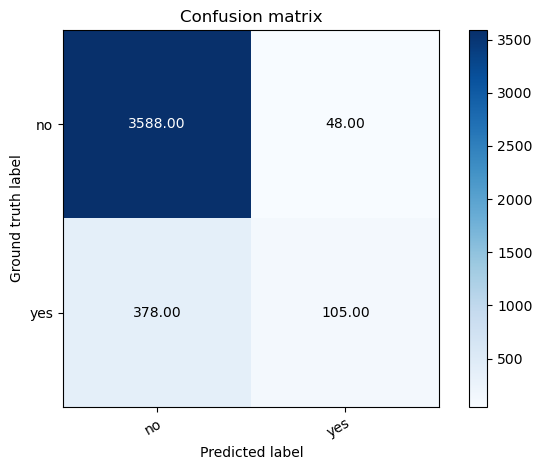

In [145]:
class_names = ["no", "yes"]
confusion_matrix = metrics.confusion_matrix(test_y, np.round(predictions))
ax, fig = plot_confusion_matrix(confusion_matrix, class_names)

In [146]:
print(f"Log confusion matrix to the model {registered_model_version.name} version {registered_model_version.version}")
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_id=registered_model_version.run_id):
    mlflow.log_figure(fig, "confusion_matrix.png")

Log confusion matrix to the model from-idea-to-prod-job-model-11-11-02-00 version 1
🏃 View run container-training-11-14-33-36 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/34/runs/c7f7d6afe6eb4b4fb4512b4a1450cb96
🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/34


In [147]:
# get the presigned url to open the MLflow UI
presigned_url = sm.create_presigned_mlflow_tracking_server_url(
    TrackingServerName=mlflow_name,
    ExpiresInSeconds=60,
    SessionExpirationDurationInSeconds=1800
)['AuthorizedUrl']

mlflow_run_link = f"{presigned_url.split('/auth')[0]}/#/experiments/1/runs/{registered_model_version.run_id}/artifacts"

In [148]:
# first open the MLflow UI - you can close a new opened window
display(Javascript('window.open("{}");'.format(presigned_url)))

<IPython.core.display.Javascript object>

In [149]:
# second open the run page in the MLflow UI
display(Javascript('window.open("{}");'.format(mlflow_run_link)))

<IPython.core.display.Javascript object>

#### Clean-up

In [150]:
# delete the endpoint to avoid cost
predictor_from_script_mode_estimator.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: from-idea-to-prod-endpoint-estimator-11-16-49-43
INFO:sagemaker:Deleting endpoint with name: from-idea-to-prod-endpoint-estimator-11-16-49-43


#### Optional: deploy from a built-in estimator
<div class="alert alert-info">This section is optional – you don't need it for the further course of the workshop. To run this session you need to run a SageMaker built-in algorithm training job in the previous section <b>Optional: train with SageMaker built-in algorithms</b>.</div>

If you have a trained estimator object, you can deploy the model in one line of code by using [`deploy()`](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator.deploy) method of the estimator. This section shows how to do this.

In [153]:
# take the XGBoost estimator that you trained in the previous section
estimator.latest_training_job.job_name

'from-idea-to-prod-training-2025-02-11-14-33-37-007'

In [103]:
# create a real-time endpoint from the trained estimator
endpoint_name_from_estimator = f"from-idea-to-prod-endpoint-estimator-{strftime('%d-%H-%M-%S', gmtime())}"

predictor_from_estimator = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    wait=True,  # Remember, predictor.predict() won't work until deployment finishes!
    # Turn on data capture, in case you want to experiment with monitoring:
    data_capture_config=sagemaker.model_monitor.DataCaptureConfig(
        enable_capture=True,
        sampling_percentage=100,
        destination_s3_uri=f"s3://{bucket_name}/{bucket_prefix}/data-capture",
    ),
    endpoint_name=endpoint_name_from_estimator,
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

INFO:sagemaker:Creating model with name: from-idea-to-prod-training-2025-02-11-15-06-00-680
INFO:sagemaker:Creating endpoint-config with name from-idea-to-prod-endpoint-estimator-11-15-06-00
INFO:sagemaker:Creating endpoint with name from-idea-to-prod-endpoint-estimator-11-15-06-00


-------!

In [105]:
# load test data as CSV files
test_x = pd.read_csv("tmp/test_x.csv", header=None)
test_y = pd.read_csv("tmp/test_y.csv", names=['y'])

In [106]:
# Predict using the real-time endpoint predictor
predictions = np.array(predictor_from_estimator.predict(test_x.values), dtype=float).squeeze()
predictions

array([0.06094802, 0.09423219, 0.20767137, ..., 0.04564261, 0.03911222,
       0.03352626])

In [107]:
test_results = pd.concat(
    [
        pd.Series(predictions, name="y_pred", index=test_x.index),
        test_x,
    ],
    axis=1,
)
test_results.head()

,y_pred,0,1,2,3,4,5,6,7,8,...,49,50,51,52,53,54,55,56,57,58
0,0.060948,25,1,999,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0.094232,28,3,999,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0.207671,38,1,999,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0.256129,32,1,999,1,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0.039112,40,1,999,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [108]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.round(predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3602,34
1,401,82


In [109]:
test_auc = roc_auc_score(test_y, test_results["y_pred"])
print(f"Test-auc: {test_auc:.4f}")

Test-auc: 0.7667


#### Clean-up

In [151]:
# delete the endpoint to avoid cost
predictor_from_estimator.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: from-idea-to-prod-endpoint-estimator-11-15-06-00
INFO:sagemaker:Deleting endpoint with name: from-idea-to-prod-endpoint-estimator-11-15-06-00


## Optional: batch transform
If you want to run off-line predictions on a large dataset or don't need a real-time endpoint, you can use SageMaker [batch-transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html). This section demonstrates how to use [SageMaker batch transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html).

<div class="alert alert-info">Run this session only if you trained an estimator with the SageMaker built-in XGBoost in the section <b>Optional: train with SageMaker built-in algorithms</b>.
</div>

In [218]:
transform_s3_url = f"s3://{bucket_name}/{bucket_prefix}/transform"
model_name = f"from-idea-to-prod-transform-{strftime('%d-%H-%M-%S', gmtime())}"

<div class="alert alert-info"> 💡 To create a transformer, use either <b>option 1</b> or <b>option 2</b>
</div>

### Option 1: create a batch transformer from the trained estimator
You can use [`EstimatorBase.transformer()`](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.EstimatorBase.transformer) to create a transformer for an estimator if you have a trained estimator. 

In [219]:
try:
    trained_estimator = estimator
except NameError:
    print("You don't have a trained estimator. Run SageMaker remote training or use a training job name.")

trained_estimator

In [220]:
transformer = trained_estimator.transformer(
    instance_count=1,
    instance_type=train_instance_type,
    accept="text/csv",
    role=sm_role,
    output_path=transform_s3_url,
    model_name=model_name,
)

INFO:sagemaker:Creating model with name: from-idea-to-prod-transform-11-21-43-27


<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <p style=" text-align: center; margin: auto;">Skip the Option 2 and go to the section <b>Run transform job</b>.
    </p>
</div>

### Option 2: load a model from a training job
Alternatively, you can load a model from a model artifact produced by a training job. You create a transformer with that model.

In [ ]:
if training_job_name is None:
    print("You don't have saved trained job name. Run SageMaker built-in algorithm training or use a trained estimator.")

In [ ]:
model = session.create_model_from_job(
    training_job_name=training_job_name, 
    name=model_name,
)

In [ ]:
transformer = sagemaker.transformer.Transformer(
    model_name=model,
    instance_count=1,
    instance_type=train_instance_type,
    accept="text/csv",
    assemble_with="Line",
    output_path=transform_s3_url,
    base_transform_job_name="from-idea-to-prod-trasform",
    sagemaker_session=session,
)

In [ ]:
!aws s3 cp ./tmp/test_x.csv {test_s3_url}/test_x.csv

In [ ]:
test_s3_url

### Run transform job



In [ ]:
transform_job_name = f"from-idea-to-prod-transform-{strftime('%d-%H-%M-%S', gmtime())}"

transformer.transform(    
    data=f"{test_s3_url}/test_x.csv",
    content_type="text/csv",
    split_type="Line", 
    job_name=transform_job_name,
    wait=True,
)

In [ ]:
while sm.describe_transform_job(
        TransformJobName=transformer._current_job_name
    )["TransformJobStatus"] != "Completed":
    time.sleep(10)
    print(f"Wait until {transformer._current_job_name} completed")

In [ ]:
transformer.output_path

### Evaluate predictions

In [ ]:
!aws s3 ls {transformer.output_path}/

In [ ]:
!aws s3 cp {transformer.output_path}/test_x.csv.out tmp/predictions.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

In [ ]:
predictions = pd.read_csv("tmp/predictions.csv", names=["y_prob"])
test_y = pd.read_csv("tmp/test_y.csv", names=['y'])

#### Crosstab

In [ ]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.array(np.round(predictions), dtype=float).squeeze(), 
    rownames=['actuals'], 
    colnames=['predictions']
)

In [ ]:
test_auc = roc_auc_score(test_y, predictions)
print(f"Test-auc: {test_auc:.4f}")

#### ROC curve

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, predictions)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Holdout/Test Data - ROC curve')
roc_display.plot()
plt.show()

#### Confusion matrix

In [ ]:
class_names = ["no", "yes"]
confusion_matrix = metrics.confusion_matrix(test_y, np.round(predictions))
ax, fig = plot_confusion_matrix(confusion_matrix, class_names)

#### Precision-recall curve

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(test_y, predictions)
average_precision= metrics.average_precision_score(test_y, predictions)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=average_precision, estimator_name='Holdout/Test Data - AUPRC curve')
pr_display.plot()
plt.show()

## Explore experiments and model registry with the MLflow UI
You can see all logged metrics, parameters, and artifacts in the MLflow UI. To launch the MLflow UI, choose **MLflow** in the **Application** pane of the Studio UI, select your MLflow server and choose **Open MLflow**:

![](img/mlflow-open.png)

In the MLflow UI you can browse experiments, runs, and registered models:

![](img/experiment-mlflow-2.png)

![](img/models-mlflow-2.png)

![](img/model-fig-mlflow.png)

---

## Optional: Hyperparameter optimization (HPO)
<div class="alert alert-info">This section is optional – you don't need it for the further course of the workshop. You can move to the <b>Clean-up</b> section.</div>

[Amazon SageMaker automatic model tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html), also called hyperparameter optimization (HPO), finds the best performing model against a defined objective metric by running many training jobs on the dataset using the algorithm and ranges of hyperparameters that you specify. SageMaker HPO supports random search, bayesian optimization, and [hyperband](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html) as tuning strategies.

In [ ]:
suffix = strftime('%d-%H-%M-%S', gmtime())
hpo_experiment_name = f"from-idea-to-prod-hpo-{suffix}"
registered_hpo_model_name = f"from-idea-to-prod-hpo-model-{suffix}"

mlflow.set_experiment(hpo_experiment_name)

In [ ]:
# import required HPO objects
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)

In [ ]:
# set up hyperparameter ranges
hp_ranges = {
    "min_child_weight": ContinuousParameter(1, 10),
    "max_depth": IntegerParameter(1, 10),
    "alpha": ContinuousParameter(0, 5),
    "eta": ContinuousParameter(0, 1),
    "colsample_bytree": ContinuousParameter(0, 1),
}

# set up the objective metric
objective = "validation:auc"

# set up the estimator in script mode
hpo_estimator = XGBoost(
    entry_point='train.py',
    source_dir='./training',
    framework_version="1.7-1",  
    hyperparameters=hyperparams,
    role=sm_role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    output_path=output_s3_url,
    base_job_name="from-idea-to-prod-training",
    environment={
        'MLFLOW_TRACKING_ARN': mlflow_arn,
        'MLFLOW_EXPERIMENT_NAME': hpo_experiment_name,
        'USER': user_profile_name,
        'REGION': region,
    }
)

# instantiate a HPO object
tuner = HyperparameterTuner(
    estimator=hpo_estimator,  # the SageMaker estimator object
    hyperparameter_ranges=hp_ranges,  # the range of hyperparameters
    max_jobs=10,  # total number of HPO jobs
    max_parallel_jobs=3,  # how many HPO jobs can run in parallel
    strategy="Bayesian",  # the internal optimization strategy of HPO
    objective_metric_name=objective,  # the objective metric to be used for HPO
    objective_type="Maximize",  # maximize or minimize the objective metric
    base_tuning_job_name="from-idea-to-prod-hpo",
    early_stopping_type="Auto",
)

### Run the HPO
Now run the HPO job. It takes about 10 minutes to complete.

In [ ]:
tuner.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
)

In [ ]:
tuner.describe()['HyperParameterTuningJobStatus']

To see the details on the HPO job in the SageMaker console click on the link constructed by the cell below:

In [ ]:
# Show the HPO job
display(
    HTML('<b>See the SageMaker <a target="top" href="https://{}.console.aws.amazon.com/sagemaker/home?region={}#/hyper-tuning-jobs/{}">HPO job</a></b>'.format(
            region, region, tuner.latest_tuning_job.job_name))
)

### See HPO results
Now get the results and see the best training job.

In [ ]:
best_training_job = tuner.describe()['BestTrainingJob']

In [ ]:
best_training_job

### Register the best HPO model in the model registry
Register the best HPO model with the hyperparameters, metrics, and model artifacts in the MLflow model registry.

In [ ]:
# find the run with the best HPO model
best_hpo_model_run_id = mlflow.search_runs(
    experiment_ids=[mlflow.get_experiment_by_name(hpo_experiment_name).experiment_id], 
    filter_string=f"tags.mlflow.source.name LIKE '%{best_training_job['TrainingJobArn'].split('/')[-1]}%'",
)['run_id'][0]

In [ ]:
best_hpo_model_run_id

In [ ]:
# Register the model
model_uri = f"runs:/{best_hpo_model_run_id}/model"
registered_hpo_model_version = mlflow.register_model(model_uri, registered_hpo_model_name)

As the next step you need to deploy the best HPO model and test it. You can choose one of the following options below.

### Run local inference with the best HPO model

In [ ]:
# get the model from the MLflow model registry
model_uri = registered_hpo_model_version.source
model = mlflow.xgboost.load_model(model_uri)

# load data
test_x = loadtxt("tmp/test_x.csv", delimiter=",")
test_y = loadtxt("tmp/test_y.csv", delimiter=",")

# predict
dtest = xgb.DMatrix(test_x)

predictions = np.array(model.predict(dtest), dtype=float).squeeze()
predictions

In [ ]:
pd.crosstab(
    index=test_y,
    columns=np.round(predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

In [ ]:
test_auc = roc_auc_score(test_y, predictions)
print(f"Test-auc: {test_auc:.4f}")

There is only a small improvements for the model metrics. It can indicate, that the XGBoost model is already at it's limit. You might want to explore other model types to improve the prediction accuracy for this use case.

---

## Clean-up
To avoid charges, remove the any deployed endpoints you created and haven't removed yet.

In [223]:
sm_client = boto3.client('sagemaker')

In [224]:
endpoints = sm_client.list_endpoints()["Endpoints"]

In [225]:
endpoints_to_delete = []

for ep in endpoints:
    print(f"Are you sure you want to delete this endpoint: {ep['EndpointName']}? (y/n)")
    choice = input()
    if choice == 'y':
        endpoints_to_delete.append(ep['EndpointName'])
        
print(f"*********** THESE ENDPOINTS WILL BE DELETED ***********")
print('\n'.join(endpoints_to_delete))
print(f"*******************************************************")

Are you sure you want to delete this endpoint: from-idea-to-prod-endpoint-estimator-11-15-15-32? (y/n)


 y


*********** THESE ENDPOINTS WILL BE DELETED ***********
from-idea-to-prod-endpoint-estimator-11-15-15-32
*******************************************************


In [226]:
for ep in endpoints_to_delete:
    try:
        print(f"Deleting the endpoint: {ep}:{sm_client.delete_endpoint(EndpointName=ep)}")
    except Exception as e:
        print(f"Exception in deleting {ep}:{e}")
        pass

Deleting the endpoint: from-idea-to-prod-endpoint-estimator-11-15-15-32:{'ResponseMetadata': {'RequestId': '1c67b295-0813-4698-9620-53376b08f5e1', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '1c67b295-0813-4698-9620-53376b08f5e1', 'content-type': 'application/x-amz-json-1.1', 'date': 'Wed, 12 Feb 2025 08:23:18 GMT', 'content-length': '0'}, 'RetryAttempts': 0}}


## Continue with the step 3
open the step 3 [notebook](03-sagemaker-pipeline.ipynb).

## Further development ideas for your real-world projects
- [Manage experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/mlflow.html)
- Use [Amazon SageMaker Data Wrangler](https://docs.aws.amazon.com/sagemaker/latest/dg/data-wrangler.html) for creating a no-code or low-code visual data processing and feature engineering flow.
- Try no-code [SageMaker Canvas](https://docs.aws.amazon.com/sagemaker/latest/dg/canvas.html) on your data to perform analysis and use automated ML to build models and generate predictions

## Additional resources
- [Using Docker containers with SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html)
- [How to create and use a custom SageMaker container: SageMaker hands-on workshop](https://sagemaker-workshop.com/custom/containers.html)
- [Amazon SageMaker Immersion Day](https://catalog.us-east-1.prod.workshops.aws/workshops/63069e26-921c-4ce1-9cc7-dd882ff62575/en-US)
- [Targeting Direct Marketing with Amazon SageMaker XGBoost](https://github.com/aws-samples/amazon-sagemaker-immersion-day/blob/master/processing_xgboost.ipynb)
- [Train a Machine Learning Model](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-train-a-model/)
- [Deploy a Machine Learning Model to a Real-Time Inference Endpoint](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-deploy-model-to-real-time-inference-endpoint/)
- [Amazon SageMaker 101 Workshop](https://catalog.us-east-1.prod.workshops.aws/workshops/0c6b8a23-b837-4e0f-b2e2-4a3ffd7d645b/en-US)
- [Amazon SageMaker 101 Workshop code repository](https://github.com/aws-samples/sagemaker-101-workshop)
- [Amazon SageMaker with XGBoost and Hyperparameter Tuning for Direct Marketing predictions](https://github.com/aws-samples/sagemaker-101-workshop/blob/main/builtin_algorithm_hpo_tabular/SageMaker%20XGBoost%20HPO.ipynb)

# Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>